# Basic convolutionnal model for cifar 10

In [14]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

In [15]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [16]:

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

model.fit(x_train, y_train,batch_size=32,epochs=10,validation_data=(x_test, y_test),shuffle=True)
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 179s 4ms/step - loss: 1.8042 - accuracy: 0.3363 - val_loss: 1.5419 - val_accuracy: 0.4456
Epoch 2/10
50000/50000 [==============================] - 188s 4ms/step - loss: 1.4990 - accuracy: 0.4539 - val_loss: 1.3479 - val_accuracy: 0.5156
Epoch 3/10
 1856/50000 [>.............................] - ETA: 2:50 - loss: 1.4477 - accuracy: 0.4860

KeyboardInterrupt: 

# Testing FGSM Attack

In [ ]:
# FAST GRADIENT SIGN METHOD (FGSM)
def FGSM(test_loader,epsilon = 0.1,min_val = -1,max_val = 1):
    correct = 0                   # Fast gradient sign method
    adv_correct = 0
    misclassified = 0
    total = 0
    adv_noise =0 
    adverserial_images = []
    y_preds = []
    y_preds_adv = []
    test_images = []
    test_label = []

    for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
    images = Variable(images,requires_grad = True)
    labels = Variable(labels)

    outputs = model(images)
    loss =criterion(outputs,labels)

    model.zero_grad()
    if images.grad is not None:
        images.grad.data.fill_(0)
    loss.backward()

    grad = torch.sign(images.grad.data) # Take the sign of the gradient.
    images_adv = torch.clamp(images.data + epsilon*grad,min_val,max_val)     # x_adv = x + epsilon*grad

    adv_output = model(Variable(images_adv)) # output by the model after adding adverserial noise

    _,predicted = torch.max(outputs.data,1)      # Prediction on the clean image
    _,adv_predicted = torch.max(adv_output.data,1) # Prediction on the image after adding adverserial noise

    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    adv_correct += (adv_predicted == labels).sum().item()
    misclassified += (predicted != adv_predicted).sum().item()

    adverserial_images.extend((images_adv).cpu().data.numpy())
    y_preds.extend(predicted.cpu().data.numpy())
    y_preds_adv.extend(adv_predicted.cpu().data.numpy())
    test_images.extend(images.cpu().data.numpy())
    test_label.extend(labels.cpu().data.numpy())


    np.save('adverserial_images.npy',adverserial_images)    # Save the adverserial labels, images
    np.save('y_preds.npy',y_preds)
    np.save('y_preds_adv.npy',y_preds_adv)
    np.save('test_images.npy',test_images)
    np.save('test_label.npy',test_label)
    print('Accuracy of the model w/0 adverserial attack on test images is : {} %'.format(100*correct/total))
    print('Accuracy of the model with adverserial attack on test images is : {} %'.format(100* adv_correct/total))
    print('Number of misclassified examples(as compared to clean predictions): {}/{}'.format(misclassified,total))



In [45]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


torch.Size([4, 3, 32, 32])


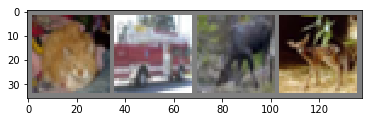

  cat truck  deer  deer


In [46]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [47]:
import torch.nn as nn
import torch.nn.functional as F


class ConvolutionalNN(nn.Module):
    def __init__(self):
        super(ConvolutionalNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


CNN = ConvolutionalNN()

In [48]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN.parameters(), lr=0.001, momentum=0.9)

In [49]:
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = CNN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')
print(CNN.conv11.weight.grad) 
print(CNN.conv21.bias.grad)

[1,  2000] loss: 2.153
[1,  4000] loss: 1.867
[1,  6000] loss: 1.692
[1,  8000] loss: 1.600
[1, 10000] loss: 1.515
[1, 12000] loss: 1.482
[2,  2000] loss: 1.412
[2,  4000] loss: 1.395
[2,  6000] loss: 1.371
[2,  8000] loss: 1.319
[2, 10000] loss: 1.318
[2, 12000] loss: 1.292
[3,  2000] loss: 1.247
[3,  4000] loss: 1.217
[3,  6000] loss: 1.214
[3,  8000] loss: 1.204
[3, 10000] loss: 1.194
[3, 12000] loss: 1.176
Finished Training


AttributeError: 'Net' object has no attribute 'conv11'

In [40]:

path = './cifar_net.pth'
torch.save(net.state_dict(), path)


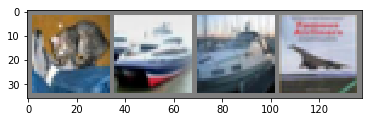

GroundTruth:    cat  ship  ship plane


In [61]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [62]:
CNN = ConvolutionalNN()
CNN.load_state_dict(torch.load(path))

outputs = CNN(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))


Predicted:    cat  ship   car  ship


In [55]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = CNN(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = CNN(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of the network on the 10000 test images: 54 %
Accuracy of plane : 57 %
Accuracy of   car : 83 %
Accuracy of  bird : 44 %
Accuracy of   cat : 30 %
Accuracy of  deer : 30 %
Accuracy of   dog : 54 %
Accuracy of  frog : 64 %
Accuracy of horse : 54 %
Accuracy of  ship : 73 %
Accuracy of truck : 46 %
